# PINNs on Graphs

Import necessary packages.

In [144]:
# Import TensorFlow and NumPy
import tensorflow as tf
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt

Define solver for PINNs.

## 1st step: Solve easy stationary equation

In [315]:
DTYPE = 'float32'

# Specify adjacency matrix
A = tf.constant([[0, 1, 1, 1, 0],
                 [1, 0, 0, 0, 1],
                 [1, 0, 0, 0, 1],
                 [1, 0, 0, 0, 0],
                 [0, 1, 1, 0, 0]], dtype=tf.int16)

n_nodes = A.shape[0]

V = tf.constant([[0., 0.],
                 [1., 0.],
                 [np.sqrt(2)/2, np.sqrt(2)/2],
                 [0., 1.],
                 [1., 1.]], dtype=DTYPE)

Dirichlet_nodes = tf.constant([0], dtype=tf.int16)
Dirichlet_vals = tf.constant([0.], dtype=DTYPE)

Determine edge matrix and weight vector.

In [318]:
Elist = []
Wlist = []
for i in range(n_nodes):
    for j in range(i+1,n_nodes):
        aij = A[i,j]
        if aij > 0:
            print('Connectivity between i: {} and j: {}'.format(i,j))
            Elist.append([i,j])            
            Wlist.append(aij.numpy())
            
E = tf.constant(Elist, dtype=tf.int16)
W = tf.constant(Wlist, dtype=DTYPE)

Connectivity between i: 0 and j: 1
Connectivity between i: 0 and j: 2
Connectivity between i: 0 and j: 3
Connectivity between i: 1 and j: 4
Connectivity between i: 2 and j: 4


In [319]:
# Bounds for parameter lambda
lb = tf.constant([0.], dtype=DTYPE)
ub = tf.constant([1.], dtype=DTYPE)

N_r = 50

In [320]:
# Define model architecture
class PINN_NeuralNet(tf.keras.Model):
    """ Set basic architecture of the PINN model."""

    def __init__(self, lb, ub,
                 output_dim=1,
                 num_hidden_layers=8,
                 num_neurons_per_layer=20,
                 activation='tanh',
                 kernel_initializer='glorot_normal',
                 **kwargs):
        super().__init__(**kwargs)

        self.num_hidden_layers = num_hidden_layers
        self.output_dim = output_dim
        self.dim = lb.shape[0]
        self.lb = lb
        self.ub = ub

        # Define NN architecture
        self.scale = tf.keras.layers.Lambda(
            lambda x: 2.0 * (x - lb) / (ub - lb) - 1.0)

        self.hidden = [tf.keras.layers.Dense(num_neurons_per_layer,
                                             activation=tf.keras.activations.get(
                                                 activation),
                                             kernel_initializer=kernel_initializer) for _ in range(self.num_hidden_layers)]
        self.out = tf.keras.layers.Dense(output_dim)

    def call(self, X):
        """Forward-pass through neural network."""
        Z = self.scale(X)
        for i in range(self.num_hidden_layers):
            Z = self.hidden[i](Z)
        return self.out(Z)

### Version 1: One NN on each edge

Set up solver class.

In [174]:
class PINNSolver(object):
    def __init__(self, NNs, N_r):
        self.NNs = NNs

        # Store collocation points
        self.N_r = N_r
        
        self.N_e = len(NNs)
        
        self.x = [tf.linspace(NNs[i].lb, NNs[i].ub, N_r+1)
                      for i in range(self.N_e)]
        
        # Initialize history of losses and global iteration counter
        self.hist = []
        self.iter = 0
        
        # Evaluate each net once to initialize weights and biases
        for i in range(self.N_e):
            NNs[i](tf.constant([[1.]]))
            
        self.trainable_variables = [self.NNs[i].trainable_variables
                                    for i in range(self.N_e)]
    
    def get_fvals(self):

        # Initilize lists for values and derivatives
        u = []
        u1x = []
        u2x = []
        
        with tf.GradientTape(persistent=True) as tape:
            
            # Watch variables representing t and x during this GradientTape
            tape.watch(self.x)
            
            # Compute current values u(t,x)
            u = []
            for i in range(self.N_e):
                u.append(self.NNs[i](self.x[i]))
                u1x.append(tape.gradient(u[i], self.x[i]))
                
        for i in range(self.N_e):
            u2x.append(tape.gradient(u1x[i], self.x[i]))
        
        del tape

        return u, u1x, u2x
    
    def fun_r(self, u, u1x, u2x):
        
        ret = []
        
        for i in range(self.N_e):
            ret.append(-u2x[i] + 1 * u[i] - 0.5)
            
        return ret
    
    def loss_fn(self):
        
        # Get values of functions and derivatives
        u, u1x, u2x = self.get_fvals()
        
        # Determine current residual
        r = self.fun_r(u, u1x, u2x)
        
        # Compute phi_r
        phi_r = tf.reduce_mean(tf.square(r))

        # Initialize loss
        loss = phi_r
        
        # Values equal in center node
        loss += tf.reduce_mean(tf.square(u[0][0]-u[1][0]))
        loss += tf.reduce_mean(tf.square(u[0][0]-u[2][0]))
        loss += tf.reduce_mean(tf.square(u[1][0]-u[2][0]))
        
        
        # Kirchhoff-Neumann condition
        loss += tf.reduce_mean(tf.square(u1x[0][0] + u1x[1][0] + u1x[2][0]))
        
        # Multiple leaves are Dirichlet nodes
        loss += tf.reduce_mean(tf.square(u[0][-1]-0.0))

        return loss
    
    def get_grad(self):
        with tf.GradientTape(persistent=True) as tape:
            # This tape is for derivatives with
            # respect to trainable variables
            tape.watch(self.trainable_variables)
            loss = self.loss_fn()

        g = tape.gradient(loss, self.trainable_variables)
        del tape

        return loss, g
    
    
    def solve_with_TFoptimizer(self, optimizer, N=1001):
        """This method performs a gradient descent type optimization."""

        for i in range(N):
            loss, g = self.get_grad()

            # Perform gradient descent step
            for j in range(self.N_e):
                optimizer.apply_gradients(zip(g[j], self.trainable_variables[j]))

            self.current_loss = loss.numpy()
            self.callback()
            

    def solve_with_ScipyOptimizer(self, method='L-BFGS-B', **kwargs):
        """This method provides an interface to solve the learning problem
        using a routine from scipy.optimize.minimize.
        (Tensorflow 1.xx had an interface implemented, which is not longer
        supported in Tensorflow 2.xx.)
        Type conversion is necessary since scipy-routines are written in
        Fortran which requires 64-bit floats instead of 32-bit floats."""

        def get_weight_tensor():
            """Function to return current variables of the model
            as 1d tensor as well as corresponding shapes as lists."""

            weight_list = []
            shape_list = []

            # Loop over all variables, i.e. weight matrices, bias vectors
            # and unknown parameters
            for i in range(self.N_e):
                for v in self.NNs[i].variables:
                    shape_list.append(v.shape)
                    weight_list.extend(v.numpy().flatten())

            weight_list = tf.convert_to_tensor(weight_list)
            return weight_list, shape_list

        x0, shape_list = get_weight_tensor()

        def set_weight_tensor(weight_list):
            """Function which sets list of weights
            to variables in the model."""
            idx = 0
            for i in range(self.N_e):
                for v in self.NNs[i].variables:
                    vs = v.shape

                    # Weight matrices
                    if len(vs) == 2:
                        sw = vs[0] * vs[1]
                        new_val = tf.reshape(
                            weight_list[idx:idx + sw], (vs[0], vs[1]))
                        idx += sw

                    # Bias vectors
                    elif len(vs) == 1:
                        new_val = weight_list[idx:idx+vs[0]]
                        idx += vs[0]

                    # Variables (in case of parameter identification setting)
                    elif len(vs) == 0:
                        new_val = weight_list[idx]
                        idx += 1

                    # Assign variables (Casting necessary since scipy requires float64 type)
                    v.assign(tf.cast(new_val, tf.float32))

        def get_loss_and_grad(w):
            """Function that provides current loss and gradient
            w.r.t the trainable variables as vector. This is mandatory
            for the LBFGS minimizer from tfp.optimizer."""

            # Update weights in model
            set_weight_tensor(w)
            # Determine value of \phi and gradient w.r.t. \theta at w
            loss, grad = self.get_grad()

            # Flatten gradient
            grad_flat = []
            for i in range(self.N_e):
                for g in grad[i]:
                    grad_flat.extend(g.numpy().flatten())

            # Store current loss for callback function
            self.current_loss = loss

            # Return value and gradient of \phi as tuple
            return loss.numpy().astype(np.float64), np.array(grad_flat, dtype=np.float64)

        return scipy.optimize.minimize(fun=get_loss_and_grad,
                                       x0=x0,
                                       jac=True,
                                       method=method,
                                       callback=self.callback,
                                       **kwargs)

            
    
    def callback(self, xr=None):
        if self.iter % 50 == 0:
            print('It {:05d}: loss = {:10.8e}'.format(
                self.iter, self.current_loss))
        self.hist.append(self.current_loss)
        self.iter += 1
        

    def plot_loss_history(self, ax=None):
        if not ax:
            fig = plt.figure(figsize=(7, 5))
            ax = fig.add_subplot(111)
        ax.semilogy(range(len(self.hist)), self.hist, 'k-')
        ax.set_xlabel('$n_{epoch}$')
        ax.set_ylabel('$\\phi^{n_{epoch}}$')
        return ax

In [175]:
NNs = []
for i,e in enumerate(E):
    NNs.append(PINN_NeuralNet(lb=lb, ub=ub))
    
print('Initialized {:d} neural nets.'.format(len(NNs)))

Initialized 3 neural nets.


In [176]:
pinn = PINNSolver(NNs, N_r=N_r)
# Solve with Adam optimizer
lr = 0.01
optim = tf.keras.optimizers.Adam(learning_rate=lr)
print('Start with TF optimizer\n')
pinn.solve_with_TFoptimizer(optim, N=201)
print('End with L-BFGS-B algorithm')
pinn.solve_with_ScipyOptimizer()

Start with TF optimizer

It 00000: loss = 1.97570932e+00
It 00050: loss = 5.15972171e-03
It 00100: loss = 6.63557556e-04
It 00150: loss = 2.72680831e-04
It 00200: loss = 1.43725323e-04
End with L-BFGS-B algorithm
It 00250: loss = 1.15498624e-05
It 00300: loss = 4.93482821e-06
It 00350: loss = 2.38965231e-06


      fun: 2.2397991870093392e-06
 hess_inv: <9003x9003 LbfgsInvHessProduct with dtype=float64>
      jac: array([-9.16104909e-06,  6.44206102e-06, -4.84160228e-06, ...,
        1.98882219e-07,  1.03103857e-05, -1.60983163e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 182
      nit: 165
   status: 0
  success: True
        x: array([ 0.03685856, -0.10811405, -0.25210018, ...,  0.20570581,
        0.16644328, -0.01365678])

Next, we try to plot the results.

Text(0.8, 0.5, 'test')

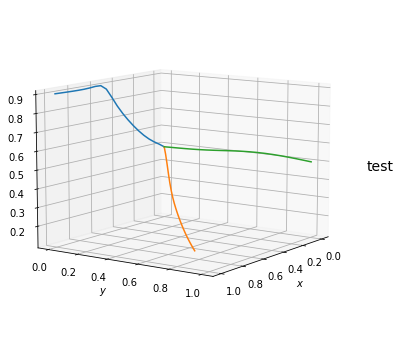

In [287]:
%matplotlib inline
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')
N = 20
lmbd = tf.linspace(lb[0], ub[0], N + 1)
Lmbd = tf.reshape(lmbd, [-1, 1])

for i, e in enumerate(E):
    xy = V[e[0].numpy()]+Lmbd*(V[e[1].numpy()]-V[e[0].numpy()])
    u = pinn.NNs[i](Lmbd)
    unum = u.numpy().flatten()
    ax.plot(xy[:,0], xy[:,1], unum)
    
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
#ax.set_zlabel('$u_\\theta(x,y)$')
ax.view_init(10, 35)
#ax = fig.add_subplot(122)
textstr='test'
plt.figtext(0.8, 0.5, textstr, fontsize=14)

## 2. Solve easy instationary equation

In [207]:
# Set boundary
tmin = 0.
tmax = 1.
xmin = 0.
xmax = 1.

# Lower bounds
lb = tf.constant([tmin, xmin], dtype=DTYPE)
ub = tf.constant([tmax, xmax], dtype=DTYPE)
N_0 = 20
N_t = 40
N_x = 20
#N_r = 50

# Set random seed for reproducible results
tf.random.set_seed(0)

# Uniform distributed points for initial boundary data
t_0 = tf.ones((N_0+1,1), dtype=DTYPE)*lb[0]
x_0 = tf.reshape(tf.linspace(lb[1],ub[1],N_0+1), (N_0+1, 1))
X_0 = tf.concat([t_0, x_0], axis=1)

# Uniform distributed collocation points
t_r = tf.linspace(lb[0], ub[0], N_t+1)
x_r = tf.linspace(lb[1], ub[1], N_x+1)
tt, xx = tf.meshgrid(t_r,x_r)
X_r = tf.concat([tf.reshape(tt,(-1,1)), tf.reshape(xx,(-1,1))], axis=1)
# Evaluate intitial condition at x_0
#u_0 = fun_u_0(x_0)


# Draw uniform sample points for initial boundary data
#x_0 = tf.random.uniform((N_0,1), lb[1], ub[1], dtype=DTYPE)

# Draw uniformly sampled collocation points
#t_r = tf.random.uniform((N_r,1), lb[0], ub[0], dtype=DTYPE)
#x_r = tf.random.uniform((N_r,1), lb[1], ub[1], dtype=DTYPE)
#X_r = tf.concat([t_r, x_r], axis=1)

We start with the version: One NN per edge.

In [279]:
class tPINNSolver(object):
    def __init__(self, NNs, X_r):
        self.NNs = NNs

        # Store collocation points
        self.N_r = N_r
        
        self.N_e = len(NNs)
        
        self.t = [ X_r[:,0:1]
                      for i in range(self.N_e)]
        self.x = [ X_r[:,1:2]
                      for i in range(self.N_e)]

        
        #self.x = [X_r[:, i:i+1] for i in range(self.model.dim)]

        # Initialize history of losses and global iteration counter
        self.hist = []
        self.iter = 0
        
        for i in range(self.N_e):
            NNs[i](tf.constant([[1., 1.]]))

        self.trainable_variables = [self.NNs[i].trainable_variables
                                    for i in range(self.N_e)]

    def get_fvals1(self, t=None, x=None):

        # Initilize lists for values and derivatives
        u = []
        u1x = []
        u1t = []
        
        if t is None:
            t = self.t
        if x is None:
            x = self.x
            
        
        with tf.GradientTape(persistent=True) as tape:
            # Watch variables representing t and x during this GradientTape
            tape.watch(t)
            tape.watch(x)
            
            # Compute current values u(t,x)
            u = []
            for i in range(self.N_e):
                u.append(self.NNs[i](tf.stack([t[i][:,0], x[i][:,0]], axis=1)))
                
        for i in range(self.N_e):
            u1t.append(tape.gradient(u[i], t[i]))
            u1x.append(tape.gradient(u[i], x[i]))

        del tape

        return u, u1t, u1x
    
    def get_fvals2(self, t=None, x=None):

        # Initilize lists for values and derivatives
        u = []
        u1x = []
        u2x = []
        u1t = []
        
        if t is None:
            t = self.t
        if x is None:
            x = self.x
        
        with tf.GradientTape(persistent=True) as tape:
            # Watch variables representing t and x during this GradientTape
            tape.watch(t)
            tape.watch(x)
            
            # Compute current values u(t,x)
            u = []
            for i in range(self.N_e):
                u.append(self.NNs[i](tf.stack([t[i][:,0], x[i][:,0]], axis=1)))
                u1x.append(tape.gradient(u[i], x[i]))
                
        for i in range(self.N_e):
            u1t.append(tape.gradient(u[i], t[i]))
            u2x.append(tape.gradient(u1x[i], x[i]))
        
        del tape

        return u, u1t, u1x, u2x

    def fun_r2(self, u, u1t, u1x, u2x):
        ret = []
        for i in range(self.N_e):
            #ret.append(u1t[i] + u1x[i] - 0.1*u2x[i]-1.)
            ret.append(u1t[i] + u1x[i] - 2*u[i]*u1x[i])

        return ret
    
    def fun_r1(self, u, u1t, u1x):
        ret = []
        for i in range(self.N_e):
            ret.append(u1t[i] + u1x[i] - 2*u[i]*u1x[i])

        return ret
    
    def loss_fn(self):
        
        # Get values of functions and derivatives
        #u, u1t, u1x, u2x = self.get_fvals2()
        
        # Compute phi_r
        #r = self.fun_r2(u, u1t, u1x, u2x)
        
        # Get values of functions and derivatives
        u, u1t, u1x = self.get_fvals1()
        
        # Compute phi_r
        r = self.fun_r1(u, u1t, u1x)
        phi_r = tf.reduce_mean(tf.square(r))

        # Initialize loss
        loss = phi_r
        
        x0nodes = slice(0,N_t+1)
        xLnodes = slice(-N_t-1,None)
        t0nodes = slice(0,None,N_t+1)
        
        # Zero initial time condition
        #for i in range(self.N_e):
            #loss += tf.reduce_mean(tf.square(u[i][t0nodes]-0.3))
        #    loss += tf.reduce_mean(tf.square(u[i][t0nodes] - tf.sin(X_r[t0nodes,1]*np.pi)))
        
        # Continuity in center node
        loss += tf.reduce_mean(tf.square(u[0][x0nodes]-u[1][x0nodes]))
        loss += tf.reduce_mean(tf.square(u[0][x0nodes]-u[2][x0nodes]))
        loss += tf.reduce_mean(tf.square(u[1][x0nodes]-u[2][x0nodes]))
        
        # Kirchhoff-Neumann condition in center node
        loss += tf.reduce_mean(tf.square(u1x[0][x0nodes] + u1x[1][x0nodes] + u1x[2][x0nodes]))
        
        # Multiple leaves are Dirichlet nodes
        loss += tf.reduce_mean(tf.square(u[0][xLnodes]-0.9))
        loss += tf.reduce_mean(tf.square(u[1][-1]-.1))
        loss += tf.reduce_mean(tf.square(u[2][-1]-.5))



        #for i in range(self.N_e):    
            #loss += tf.reduce_mean(tf.square(u[i]))

        return loss    
    
    def get_grad(self):
        with tf.GradientTape(persistent=True) as tape:
            # This tape is for derivatives with
            # respect to trainable variables
            tape.watch(self.trainable_variables)
            loss = self.loss_fn()

        g = tape.gradient(loss, self.trainable_variables)
        del tape

        return loss, g
    
    
    def solve_with_TFoptimizer(self, optimizer, N=1001):
        """This method performs a gradient descent type optimization."""

        for i in range(N):
            loss, g = self.get_grad()

            # Perform gradient descent step
            for j in range(self.N_e):
                optimizer.apply_gradients(zip(g[j], self.trainable_variables[j]))

            self.current_loss = loss.numpy()
            self.callback()
            

    def solve_with_ScipyOptimizer(self, method='L-BFGS-B', **kwargs):
        """This method provides an interface to solve the learning problem
        using a routine from scipy.optimize.minimize.
        (Tensorflow 1.xx had an interface implemented, which is not longer
        supported in Tensorflow 2.xx.)
        Type conversion is necessary since scipy-routines are written in
        Fortran which requires 64-bit floats instead of 32-bit floats."""

        def get_weight_tensor():
            """Function to return current variables of the model
            as 1d tensor as well as corresponding shapes as lists."""

            weight_list = []
            shape_list = []

            # Loop over all variables, i.e. weight matrices, bias vectors
            # and unknown parameters
            for i in range(self.N_e):
                for v in self.NNs[i].variables:
                    shape_list.append(v.shape)
                    weight_list.extend(v.numpy().flatten())

            weight_list = tf.convert_to_tensor(weight_list)
            return weight_list, shape_list

        x0, shape_list = get_weight_tensor()

        def set_weight_tensor(weight_list):
            """Function which sets list of weights
            to variables in the model."""
            idx = 0
            for i in range(self.N_e):
                for v in self.NNs[i].variables:
                    vs = v.shape

                    # Weight matrices
                    if len(vs) == 2:
                        sw = vs[0] * vs[1]
                        new_val = tf.reshape(
                            weight_list[idx:idx + sw], (vs[0], vs[1]))
                        idx += sw

                    # Bias vectors
                    elif len(vs) == 1:
                        new_val = weight_list[idx:idx+vs[0]]
                        idx += vs[0]

                    # Variables (in case of parameter identification setting)
                    elif len(vs) == 0:
                        new_val = weight_list[idx]
                        idx += 1

                    # Assign variables (Casting necessary since scipy requires float64 type)
                    v.assign(tf.cast(new_val, tf.float32))

        def get_loss_and_grad(w):
            """Function that provides current loss and gradient
            w.r.t the trainable variables as vector. This is mandatory
            for the LBFGS minimizer from tfp.optimizer."""

            # Update weights in model
            set_weight_tensor(w)
            # Determine value of \phi and gradient w.r.t. \theta at w
            loss, grad = self.get_grad()

            # Flatten gradient
            grad_flat = []
            for i in range(self.N_e):
                for g in grad[i]:
                    grad_flat.extend(g.numpy().flatten())

            # Store current loss for callback function
            self.current_loss = loss

            # Return value and gradient of \phi as tuple
            return loss.numpy().astype(np.float64), np.array(grad_flat, dtype=np.float64)

        return scipy.optimize.minimize(fun=get_loss_and_grad,
                                       x0=x0,
                                       jac=True,
                                       method=method,
                                       callback=self.callback,
                                       **kwargs)

            
    
    def callback(self, xr=None):
        if self.iter % 50 == 0:
            print('It {:05d}: loss = {:10.8e}'.format(
                self.iter, self.current_loss))
        self.hist.append(self.current_loss)
        self.iter += 1
        

    def plot_loss_history(self, ax=None):
        if not ax:
            fig = plt.figure(figsize=(7, 5))
            ax = fig.add_subplot(111)
        ax.semilogy(range(len(self.hist)), self.hist, 'k-')
        ax.set_xlabel('$n_{epoch}$')
        ax.set_ylabel('$\\phi^{n_{epoch}}$')
        return ax

In [280]:
x0nodes = slice(0,N_t+1)
t0nodes = slice(0,None,N_t+1)

tf.sin(X_r[t0nodes,1]*np.pi)

<tf.Tensor: shape=(21,), dtype=float32, numpy=
array([ 0.0000000e+00,  1.5643448e-01,  3.0901700e-01,  4.5399055e-01,
        5.8778524e-01,  7.0710677e-01,  8.0901706e-01,  8.9100653e-01,
        9.5105654e-01,  9.8768836e-01,  1.0000000e+00,  9.8768830e-01,
        9.5105648e-01,  8.9100647e-01,  8.0901700e-01,  7.0710677e-01,
        5.8778524e-01,  4.5399037e-01,  3.0901679e-01,  1.5643445e-01,
       -8.7422777e-08], dtype=float32)>

In [281]:
NNs = []
for i,e in enumerate(E):
    NNs.append(PINN_NeuralNet(lb=lb, ub=ub))
    
print('Initialized {:d} neural nets.'.format(len(NNs)))

pinn = tPINNSolver(NNs, X_r)

Initialized 3 neural nets.


In [282]:
# Solve with Adam optimizer
lr = 0.001
optim = tf.keras.optimizers.Adam(learning_rate=lr)
print('Start with TF optimizer\n')
pinn.solve_with_TFoptimizer(optim, N=201)
print('End with L-BFGS-B algorithm')
pinn.solve_with_ScipyOptimizer()

Start with TF optimizer

It 00000: loss = 5.90310335e+00
It 00050: loss = 2.23391037e-02
It 00100: loss = 1.05934143e-02
It 00150: loss = 9.04439297e-03
It 00200: loss = 8.13162792e-03
End with L-BFGS-B algorithm
It 00250: loss = 4.41228412e-03
It 00300: loss = 2.84227333e-03
It 00350: loss = 2.00381549e-03
It 00400: loss = 1.33626966e-03
It 00450: loss = 9.95693263e-04
It 00500: loss = 8.79873463e-04
It 00550: loss = 7.67395366e-04
It 00600: loss = 6.72913680e-04
It 00650: loss = 6.06374815e-04
It 00700: loss = 5.35626721e-04
It 00750: loss = 4.40803764e-04
It 00800: loss = 3.97262280e-04
It 00850: loss = 3.40495724e-04
It 00900: loss = 3.16003599e-04
It 00950: loss = 2.80005479e-04
It 01000: loss = 2.38947745e-04
It 01050: loss = 1.99910806e-04
It 01100: loss = 1.68856874e-04
It 01150: loss = 1.45668790e-04
It 01200: loss = 1.23484264e-04
It 01250: loss = 1.12223315e-04
It 01300: loss = 9.57545271e-05
It 01350: loss = 8.34637249e-05
It 01400: loss = 7.50380932e-05
It 01450: loss = 7.

      fun: 3.283758269390091e-05
 hess_inv: <9063x9063 LbfgsInvHessProduct with dtype=float64>
      jac: array([-8.34204475e-05,  1.38122850e-04,  3.32966883e-05, ...,
       -2.69948177e-05,  5.97441322e-05, -1.16601273e-04])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 1898
      nit: 1727
   status: 0
  success: True
        x: array([ 0.16883815, -0.30216919,  0.08961437, ..., -0.51823477,
       -0.43977678,  0.0689004 ])

<IPython.core.display.Javascript object>


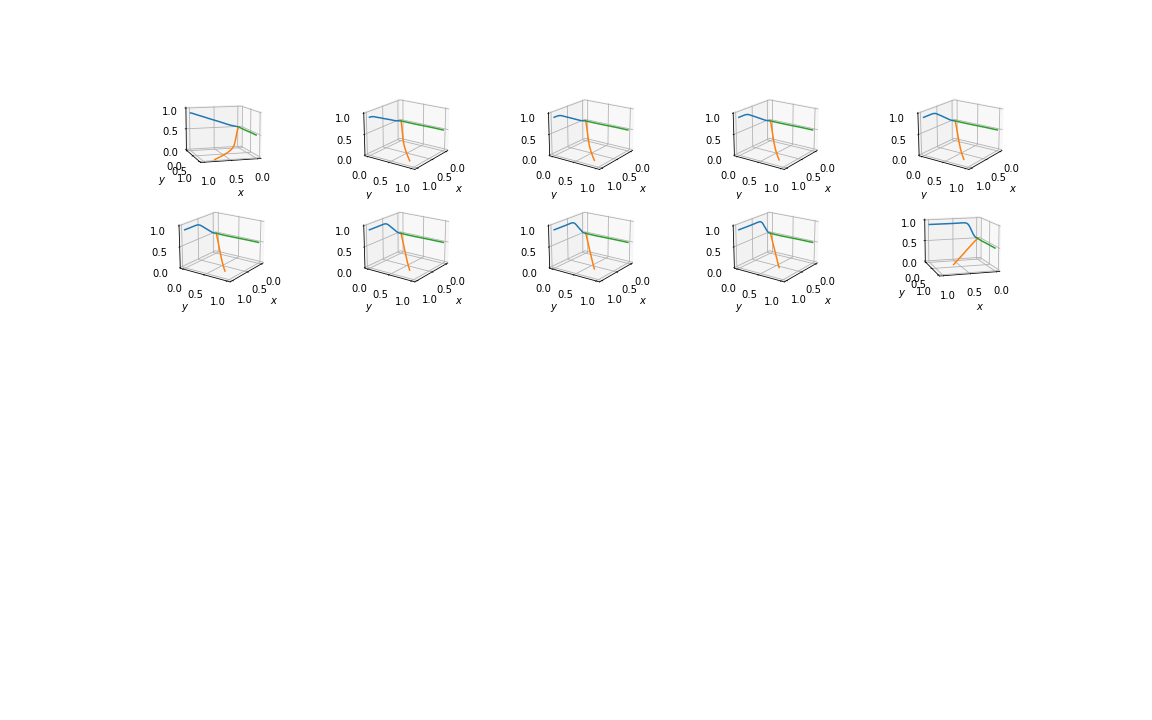

In [278]:
%matplotlib notebook
fig = plt.figure(figsize=(16, 10))

Nt = 9
Nx = 30

tspace = tf.linspace(lb[0], ub[0], Nt + 1)
xspace = tf.reshape(tf.linspace(lb[1], ub[1], Nx + 1), [-1, 1])

for j in range(Nt+1):
    ax = fig.add_subplot(int(np.sqrt(N))+1,int(np.sqrt(N))+1,j+1, projection='3d')
    #Lmbd = tf.reshape(lmbd, [-1, 1])
    t0 = tf.ones_like(xspace)*tspace[j]
    #(lb[0]+(j+.0)/N*(ub[0]-lb[0]))
    for i, e in enumerate(E):
        xy = V[e[0].numpy()]+xspace*(V[e[1].numpy()]-V[e[0].numpy()])
        u = pinn.NNs[i](tf.concat([t0,xspace],axis=1))
        unum = u.numpy().flatten()
        ax.plot(xy[:,0], xy[:,1], unum)
    
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlim([0.,1.])
    #ax.set_zlabel('$u_\\theta(x,y)$')
    ax.view_init(19, 35)